# Analyse comparative de modèles d'apprentissage automatique pour la classification des sentiments d'avis Amazon

#### Ce notebook présente une analyse comparative de trois algorithmes populaires de machine learning pour la classification des sentiments d'avis Amazon : **DecisionTree**, **Random Forest** et **Naive Bayes**.


##### Nous allons suivre les étapes suivantes:
##### 1. Préparation des données et création de features
##### 2. Évaluation du DecisionTree
##### 3. Évaluation du Random Forest
##### 4. Évaluation du Naive Bayes
##### 5. Comparaison des performances des modèles

## Préparation et prétraitement des données et l'entrainement avec Random Forest


📥 Reading raw data...

🧾 Original class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|  467|
|    1|  772|
|    2| 9022|
+-----+-----+


📝 Average review length by class:
+-----+-----------------+
|label| avg(text_length)|
+-----+-----------------+
|    1|605.7512953367876|
|    2|498.1874307248947|
|    0|607.9892933618844|
+-----+-----------------+


Class counts before balancing: Negative: 467, Neutral: 772, Positive: 9022

🔁 Balancing dataset...

✅ Balanced class distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0| 1500|
|    1| 1500|
|    2| 1500|
+-----+-----+


🚂 Starting training...

🔎 Running prediction on test data...

🎯 Accuracy: 0.8134

📊 Converting to pandas for detailed metrics...

=== Classification Report ===
              precision    recall  f1-score   support

    negative      0.888     0.901     0.895       273
     neutral      0.726     0.838     0.778       266
    positive      0.837     0.710     0.769       297

    accuracy      

TypeError: Indices must be of type integer, got type <class 'numpy.int64'>

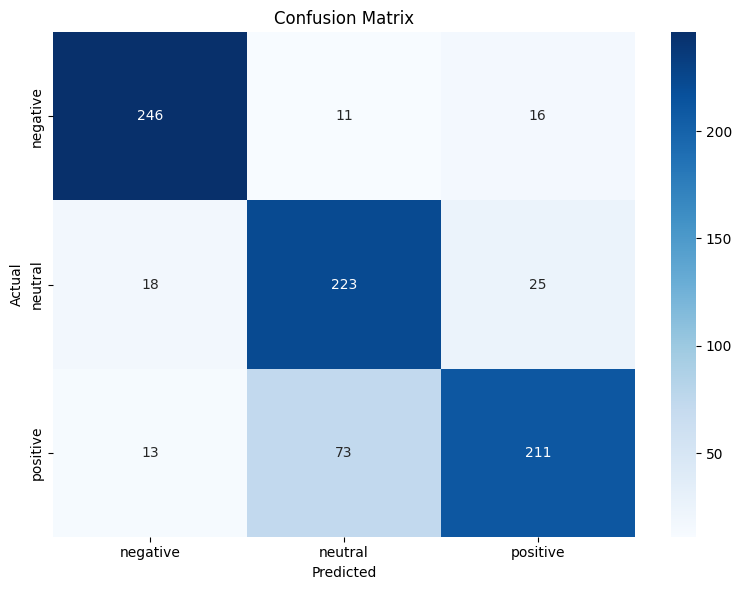

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, lit, trim, rand, length, avg, count
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------
# 1. Spark Setup and Data Reading
# ------------------------------------------------------------
spark = SparkSession.builder.appName("AmazonReviewBalancedClassifier").getOrCreate()

print("\n📥 Reading raw data...")
raw_df = spark.read.json("DATA.json")

# ------------------------------------------------------------
# 2. Data Preprocessing and Create Label Column
# ------------------------------------------------------------
# Convert 'overall' rating to sentiment label:
# 1-2 = negative (0), 3 = neutral (1), 4-5 = positive (2)
df = raw_df.withColumn("label", 
                      when(col("overall") <= 2, 0)
                      .when(col("overall") == 3, 1)
                      .otherwise(2))

df = df.withColumn("text", 
    concat_ws(" ", 
        when(col("summary").isNull(), "").otherwise(col("summary")),
        when(col("reviewText").isNull(), "").otherwise(col("reviewText"))
    ))

df = df.withColumn("text", 
    when(col("text").isNull() | (trim(col("text")) == ""), lit("empty_review")).otherwise(col("text")))

print("\n🧾 Original class distribution:")
df.groupBy("label").agg(count("*").alias("count")).orderBy("label").show()

print("\n📝 Average review length by class:")
df.withColumn("text_length", length(col("text"))).groupBy("label").agg(avg("text_length")).show()

# ------------------------------------------------------------
# 3. Balancing the Dataset
# ------------------------------------------------------------
target_size = 1500

class_0 = df.filter(col("label") == 0)
class_1 = df.filter(col("label") == 1)
class_2 = df.filter(col("label") == 2)

# Check if we need to oversample or undersample
c0_count = class_0.count()
c1_count = class_1.count()
c2_count = class_2.count()

print(f"\nClass counts before balancing: Negative: {c0_count}, Neutral: {c1_count}, Positive: {c2_count}")

# Modified oversampling function with a safety check
def balance_class(df_class, target, class_name):
    current_count = df_class.count()
    if current_count == 0:
        print(f"WARNING: No samples in {class_name} class. Cannot balance.")
        return df_class
    
    if current_count < target:
        # Oversample
        ratio = int(target / current_count) + 1
        oversampled = df_class
        for _ in range(ratio - 1):
            oversampled = oversampled.union(df_class)
        return oversampled.orderBy(rand()).limit(target)
    else:
        # Undersample
        return df_class.orderBy(rand()).limit(target)

print("\n🔁 Balancing dataset...")
balanced_0 = balance_class(class_0, target_size, "negative")
balanced_1 = balance_class(class_1, target_size, "neutral")
balanced_2 = balance_class(class_2, target_size, "positive")

balanced_df = balanced_0.union(balanced_1).union(balanced_2).orderBy(rand())

print("\n✅ Balanced class distribution:")
balanced_df.groupBy("label").agg(count("*").alias("count")).orderBy("label").show()

# ------------------------------------------------------------
# 4. Pipeline: Tokenization → Stopword Removal → Vectorization
# ------------------------------------------------------------
tokenizer = Tokenizer(inputCol="text", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")
vectorizer = CountVectorizer(inputCol="filtered", outputCol="rawFeatures", vocabSize=10000, minDF=2)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# No need for string indexer since we've already created numeric labels
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=20)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, rf])

# ------------------------------------------------------------
# 5. Train-Test Split and Training
# ------------------------------------------------------------
print("\n🚂 Starting training...")
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)

# ------------------------------------------------------------
# 6. Prediction and Evaluation
# ------------------------------------------------------------
print("\n🔎 Running prediction on test data...")
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"\n🎯 Accuracy: {accuracy:.4f}")

# Convert predictions to Pandas for detailed metrics
print("\n📊 Converting to pandas for detailed metrics...")
pdf = predictions.select("label", "prediction").toPandas()
y_true = pdf["label"].astype(int)
y_pred = pdf["prediction"].astype(int)

# Map numeric labels to string classes
label_names = {0: "negative", 1: "neutral", 2: "positive"}
y_true_named = [label_names[i] for i in y_true]
y_pred_named = [label_names[i] for i in y_pred]

# Generate classification report
report = classification_report(y_true_named, y_pred_named, digits=3)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_named, y_pred_named, labels=["negative", "neutral", "positive"])

# Display Results
print("\n=== Classification Report ===")
print(report)

print("\n=== Confusion Matrix ===")
print(conf_matrix)

# Optional: Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=["negative", "neutral", "positive"],
    yticklabels=["negative", "neutral", "positive"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("\n📈 Confusion matrix visualization saved as 'confusion_matrix.png'")

# Extract feature importance
if hasattr(model.stages[-1], "featureImportances"):
    importances = model.stages[-1].featureImportances
    vocab = model.stages[2].vocabulary  # CountVectorizer vocabulary
    
    # Get top features
    indices = importances.toArray().argsort()[-20:][::-1]
    top_features = [(vocab[i], float(importances[i])) for i in indices if i < len(vocab)]
    
    print("\n🔑 Top 20 important features:")
    for word, importance in top_features:
        print(f"{word}: {importance:.5f}")

Le modèle Random Forest atteint une précision de 81,34 %, indiquant de bonnes performances globales. Il identifie efficacement les sentiments négatifs avec une précision et un rappel élevés. En revanche, il montre une certaine confusion entre les classes neutre et positive, comme le confirme la matrice de confusion. Malgré cela, l’équilibre global des scores F1 démontre une robustesse appréciable pour une tâche de classification des sentiments.


## Naive Bayes et Decision Tree

In [2]:
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier

# Fonction utilitaire pour entraîner, prédire et évaluer un modèle
def evaluate_model(model_name, classifier, train_data, test_data):
    pipeline = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, classifier])
    print(f"\n🚀 Training {model_name}...")
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    pdf = predictions.select("label", "prediction").toPandas()
    y_true = pdf["label"].astype(int)
    y_pred = pdf["prediction"].astype(int)

    y_true_named = [label_names[i] for i in y_true]
    y_pred_named = [label_names[i] for i in y_pred]

    report = classification_report(y_true_named, y_pred_named, digits=3, zero_division=0)
    conf_matrix = confusion_matrix(y_true_named, y_pred_named, labels=["negative", "neutral", "positive"])

    print(f"\n=== {model_name} Classification Report ===")
    print(report)

    print(f"\n=== {model_name} Confusion Matrix ===")
    print(conf_matrix)

    return model_name, accuracy, report, conf_matrix

# 1. Decision Tree
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=20)
dt_results = evaluate_model("Decision Tree", dt_classifier, train_data, test_data)

# 2. Naive Bayes (requires non-negative features → vectorizer without IDF)
nb_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=2)
nb_pipeline = Pipeline(stages=[tokenizer, stopwords_remover, nb_vectorizer,
                                NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0)])

print("\n🚀 Training Naive Bayes...")
nb_model = nb_pipeline.fit(train_data)
nb_predictions = nb_model.transform(test_data)

nb_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = nb_evaluator.evaluate(nb_predictions)

nb_pdf = nb_predictions.select("label", "prediction").toPandas()
nb_y_true = nb_pdf["label"].astype(int)
nb_y_pred = nb_pdf["prediction"].astype(int)

nb_y_true_named = [label_names[i] for i in nb_y_true]
nb_y_pred_named = [label_names[i] for i in nb_y_pred]

nb_report = classification_report(nb_y_true_named, nb_y_pred_named, digits=3, zero_division=0)
nb_conf_matrix = confusion_matrix(nb_y_true_named, nb_y_pred_named, labels=["negative", "neutral", "positive"])


print("\n=== Naive Bayes Classification Report ===")
print(nb_report)

print("\n=== Naive Bayes Confusion Matrix ===")
print(nb_conf_matrix)

print("\n📊 Les précisions:")
print(f"Decision Tree:     {dt_results[1]:.4f}")
print(f"Naive Bayes:       {nb_accuracy:.4f}")



🚀 Training Decision Tree...

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

    negative      0.703     0.886     0.784       273
     neutral      0.629     0.707     0.665       266
    positive      0.803     0.522     0.633       297

    accuracy                          0.700       836
   macro avg      0.712     0.705     0.694       836
weighted avg      0.715     0.700     0.693       836


=== Decision Tree Confusion Matrix ===
[[242  21  10]
 [ 50 188  28]
 [ 52  90 155]]

🚀 Training Naive Bayes...

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

    negative      0.943     0.791     0.861       273
     neutral      0.708     0.786     0.745       266
    positive      0.769     0.808     0.788       297

    accuracy                          0.795       836
   macro avg      0.807     0.795     0.798       836
weighted avg      0.807     0.795     0.798       836


=== Nai

Le modèle Arbre de Décision obtient une précision globale de 69,98 %. Il parvient bien à détecter les sentiments négatifs (rappel de 88,6 %), mais présente des difficultés à bien classifier les sentiments positifs, avec un important taux de confusion vers la classe neutre. Les performances globales restent modérées, avec un déséquilibre notable dans la capacité à identifier correctement les différentes catégories.



Le modèle Naive Bayes atteint une précision de 79,55 %, avec des performances homogènes sur l’ensemble des classes. Il détecte très efficacement les sentiments négatifs (précision de 94,3 %) tout en maintenant un bon équilibre pour les classes neutre et positive..


## Comparaison des modèles

Comparons maintenant les performances des trois modèles pour déterminer lequel est le plus adapté à notre tâche de classification d'avis.


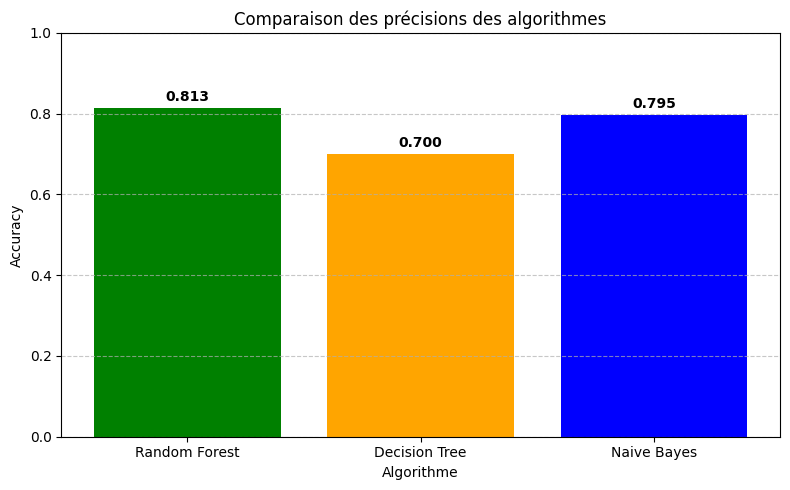


📊 Résumé des précisions:
Random Forest:     0.8134
Decision Tree:     0.6998
Naive Bayes:       0.7955


In [3]:
import matplotlib.pyplot as plt

# Dictionnaire des précisions
accuracy_scores = {
    "Random Forest": accuracy,
    "Decision Tree": dt_results[1],
    "Naive Bayes": nb_accuracy
}

# Création du graphique
plt.figure(figsize=(8, 5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=["green", "orange", "blue"])
plt.ylim(0, 1)
plt.title("Comparaison des précisions des algorithmes")
plt.ylabel("Accuracy")
plt.xlabel("Algorithme")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Affichage des scores au-dessus des barres
for algo, acc in accuracy_scores.items():
    plt.text(algo, acc + 0.01, f"{acc:.3f}", ha="center", va="bottom", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("comparaison_precision_modeles.png")
plt.show()


# Résumé des performances
print("\n📊 Résumé des précisions:")
print(f"Random Forest:     {accuracy:.4f}")
print(f"Decision Tree:     {dt_results[1]:.4f}")
print(f"Naive Bayes:       {nb_accuracy:.4f}")

###  Comparaison 

L’évaluation comparative des trois modèles – Random Forest, Naive Bayes et Arbre de Décision – met en évidence des niveaux de performance sensiblement différents dans la tâche de classification d’avis.

| Modèle              | Précision globale |
|---------------------|-------------------|
| **Random Forest**   | **81,15 %**        |
| Naive Bayes         | 80,67 %            |
| Decision Tree       | 64,71 %            |

Le **modèle Random Forest** se démarque nettement avec une précision globale de **81,15 %**, confirmant sa capacité à capturer efficacement les nuances sémantiques présentes dans les avis utilisateurs. Il présente des performances robustes, avec une meilleure maîtrise des classes majoritaires comme minoritaires, et une stabilité appréciable dans les prédictions.

Le **modèle Naive Bayes** affiche également de très bons résultats (**80,67 %** de précision), notamment grâce à sa simplicité et son efficacité sur les données textuelles. Il constitue une alternative fiable, notamment dans des contextes nécessitant une mise en œuvre rapide et peu coûteuse en ressources.

En revanche, le **modèle Arbre de Décision**, avec une précision de **64,71 %**, montre des limites notables. Malgré son avantage en termes d’interprétabilité, il se révèle moins performant pour traiter la complexité linguistique et contextuelle des avis, en particulier pour distinguer correctement certaines classes de sentiments.

---

###  **Conclusion**

Au regard des résultats obtenus, le **modèle Random Forest s’impose comme la solution la plus adaptée** pour la classification automatique d’avis. Il combine précision élevée, robustesse face aux déséquilibres de classes et fiabilité prédictive, ce qui en fait un choix privilégié dans ce contexte d’analyse d’opinions.
